In [4]:
import numpy as np
import random
import pandas as pd
import io
import json
import urllib
import re
import unicodedata
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Dense, Embedding, Input
from keras import Model
from keras.utils import plot_model, pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.text import tokenizer_from_json

In [5]:
url = 'https://raw.githubusercontent.com/futuremojo/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_train.txt'
urllib.request.urlretrieve(url, 'hun_eng_train.txt')

('hun_eng_train.txt', <http.client.HTTPMessage at 0x27946071e10>)

In [6]:
with open('hun_eng_train.txt', encoding = 'utf-8') as file:
    hun_eng_train = [line.rstrip() for line in file]
    
print(hun_eng_train[:4])

["Teszek rá, mit mondasz!<sep>I don't care what you say.", 'Több olyan ember kell nekünk a csapatba, mint amilyen te vagy.<sep>We need more people like you on our team.', 'Vigyázz a gyerekeimre!<sep>Take care of my children.', 'Miért van szüksége önöknek két kerékpárra?<sep>Why do you need two bicycles?']


In [7]:
separator = '<sep>'

train_input, train_target = map(list, zip(*[line.split(separator) for line in hun_eng_train]))

print(train_input[:3])
print(train_target[:3])

['Teszek rá, mit mondasz!', 'Több olyan ember kell nekünk a csapatba, mint amilyen te vagy.', 'Vigyázz a gyerekeimre!']
["I don't care what you say.", 'We need more people like you on our team.', 'Take care of my children.']


In [8]:
def unicode_normalization(text):
    return ''.join([word for word in unicodedata.normalize('NFD', text) 
                    if unicodedata.category(word) != 'Mn'])
    
    
def text_preprocess(text):
    text = unicode_normalization(text)
    text = re.sub(r'([?.!,¿])', r' \1 ', text)
    text = re.sub('["  "]+', " ", text)
    text = text.lower().strip()
    
    return text

train_input_preprocessed = [text_preprocess(line) for line in train_input]
train_target_preprocessed = [text_preprocess(line) for line in train_target]

In [9]:
print(train_input_preprocessed[:3])
print(train_target_preprocessed[:3])

['teszek ra , mit mondasz !', 'tobb olyan ember kell nekunk a csapatba , mint amilyen te vagy .', 'vigyazz a gyerekeimre !']
["i don't care what you say .", 'we need more people like you on our team .', 'take care of my children .']


In [10]:
def target_tagging(text):
    return list(map(lambda x: '<sos> ' + x + ' <eos>', text))

train_target_tagged = target_tagging(train_target_preprocessed)

In [11]:
print(train_target_tagged[:3])

["<sos> i don't care what you say . <eos>", '<sos> we need more people like you on our team . <eos>', '<sos> take care of my children . <eos>']


In [12]:
hun_tokenizer = Tokenizer(oov_token= '<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
hun_tokenizer.fit_on_texts(train_input_preprocessed)
hun_vocab_size = len(hun_tokenizer.word_index) + 1
print(hun_vocab_size)

eng_tokenizer = Tokenizer(oov_token='<unk>', filters = '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
eng_tokenizer.fit_on_texts(train_target_tagged)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
print(eng_vocab_size)

38539
10556


In [13]:
def decoder_input_target_generator(tokenizer, sentences):
    seqs = tokenizer.texts_to_sequences(sentences)
    decoder_inputs = [seq[:-1] for seq in seqs]
    decoder_outputs = [seq[1:] for seq in seqs]
    
    return decoder_inputs, decoder_outputs

encoder_inputs = hun_tokenizer.texts_to_sequences(train_input_preprocessed)
decoder_inputs, decoder_outputs = decoder_input_target_generator(eng_tokenizer, train_target_tagged)


In [14]:
max_encoder_input_len = max([len(lis) for lis in encoder_inputs])
max_decoder_input_len = max([len(lis) for lis in decoder_inputs])
max_decoder_output_len = max([len(lis) for lis in decoder_outputs])

print(max_encoder_input_len)
print(max_decoder_input_len)
print(max_decoder_output_len)

37
34
34


In [15]:
encoder_inputs_padded = pad_sequences(encoder_inputs, maxlen = max_encoder_input_len, padding = 'post', truncating='post')
decoder_inputs_padded = pad_sequences(decoder_inputs, maxlen = max_decoder_input_len, padding = 'post', truncating='post')
decoder_outputs_padded = pad_sequences(decoder_outputs, maxlen = max_decoder_output_len, padding = 'post', truncating='post')

print(encoder_inputs_padded[1])
print(decoder_inputs_padded[1])
print(decoder_outputs_padded[1])

[ 153   56  145   17  152    3 7232    4   45 1670   44   23    2    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
[  2  25  55 117 144  33   7  35 139 794   4   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 25  55 117 144  33   7  35 139 794   4   3   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [16]:
url = 'https://raw.githubusercontent.com/futuremojo/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_val.txt'
urllib.request.urlretrieve(url, 'hun_eng_test.txt')

with open('hun_eng_test.txt', encoding = 'utf-8') as file:
    hun_eng_test = [line.rstrip() for line in file]
    
print(hun_eng_test[:3])

['Abbahagyhatom, ha zavar.<sep>If it bothers you, I can stop doing this.', 'Nős voltam.<sep>I was married.', 'Ez a zene az idegeire megy.<sep>That music gets on his nerves.']


In [17]:
def test_data_generator(sentence_list):
    
    test_input, test_target = map(list, zip(*[sentence.split('<sep>') for sentence in sentence_list]))
    
    test_preprocessed_input = [text_preprocess(sentence) for sentence in test_input]
    test_preprocessed_target = [text_preprocess(sentence) for sentence in test_target]
    
    test_tagged_target = target_tagging(test_preprocessed_target)
    
    test_encoder_input = hun_tokenizer.texts_to_sequences(test_preprocessed_input)
    test_decoder_input, test_decoder_output = decoder_input_target_generator(eng_tokenizer, test_tagged_target)
    
    test_encoder_padded_input = pad_sequences(test_encoder_input, maxlen = max_encoder_input_len, padding = 'post', truncating= 'post')
    test_decoder_padded_input = pad_sequences(test_decoder_input, maxlen = max_decoder_input_len, padding = 'post', truncating= 'post')
    test_decoder_padded_output = pad_sequences(test_decoder_output, maxlen = max_decoder_input_len, padding = 'post', truncating= 'post')
    
    return test_encoder_padded_input, test_decoder_padded_input, test_decoder_padded_output



test_encoder_padded_input, test_decoder_padded_input, test_decoder_padded_output = test_data_generator(hun_eng_test)

In [18]:
print(test_encoder_padded_input[1])
print(test_decoder_padded_input[1])
print(test_decoder_padded_output[1])

[1056   74    2    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
[  2   5  21 302   4   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  5  21 302   4   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [17]:
output_dim = 128
lstm_dim = 256
dropout = 0.2
batchsize = 32
epochs = 30



encoder_input_layer = Input(shape = [None], name = 'encoder_input_layer')

encoder_embedding_layer = Embedding(input_dim= hun_vocab_size,
                                    output_dim = output_dim,
                                    mask_zero=True,
                                    name = 'encoder_embedding_layer')

encoder_embedding_outputs = encoder_embedding_layer(encoder_input_layer)

encoder_lstm_layer = LSTM(units = lstm_dim,
                          return_state=True,
                          dropout = dropout,
                          name = 'encoder_lstm_layer')

encoder_output, state_h, state_c = encoder_lstm_layer(encoder_embedding_outputs)

encoder_state = (state_h, state_c)

In [18]:
decoder_input_layer = Input(shape=[None], name = 'decoder_input_layer')

decoder_embedding_layer = Embedding(input_dim = eng_vocab_size,
                                    output_dim = output_dim,
                                    mask_zero = True,
                                    name = 'decoder_embedding_layer')

decoder_embedding_output = decoder_embedding_layer(decoder_input_layer)

decoder_lstm_layer = LSTM(units = lstm_dim,
                          return_sequences= True,
                          return_state = True,
                          dropout = dropout,
                          name = 'decoder_lstm_layer')

decoder_output, _, _ = decoder_lstm_layer(decoder_embedding_output, initial_state = encoder_state)

decoder_dense_layer = Dense(units = eng_vocab_size, 
                            activation= 'softmax',
                            name = 'decoder_dense_layer')

decoder_prob_output = decoder_dense_layer(decoder_output)

In [19]:
model = Model([encoder_input_layer, decoder_input_layer], decoder_prob_output, name = 'hun_eng_translator')

model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics = 'sparse_categorical_accuracy')

model.summary()

Model: "hun_eng_translator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input_layer (Input  [(None, None)]               0         []                            
 Layer)                                                                                           
                                                                                                  
 decoder_input_layer (Input  [(None, None)]               0         []                            
 Layer)                                                                                           
                                                                                                  
 encoder_embedding_layer (E  (None, None, 128)            4932992   ['encoder_input_layer[0][0]'] 
 mbedding)                                                                       

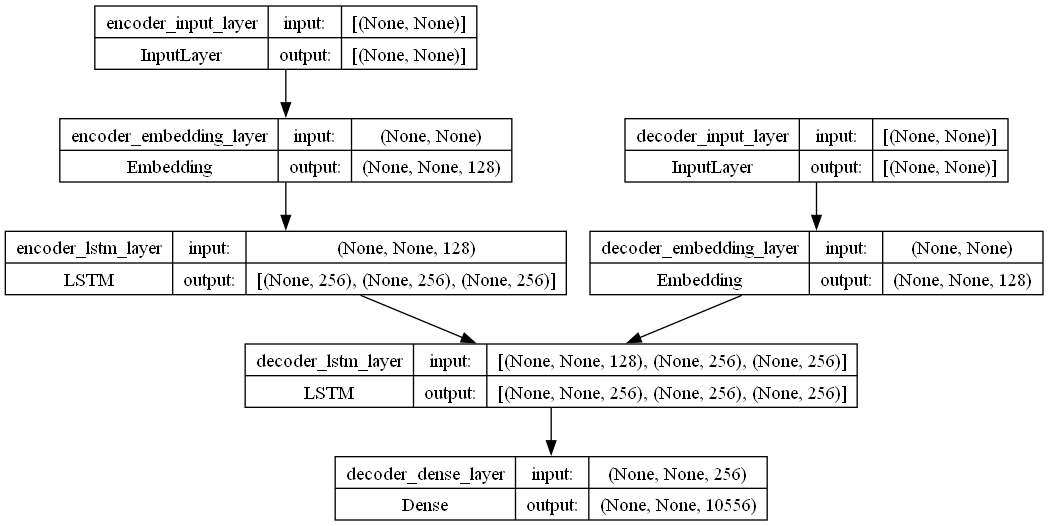

In [20]:
plot_model(model, show_shapes = True, show_layer_names=True)

In [24]:
path = 'cp.ckpt'

cp_callback = ModelCheckpoint(path, monitor= 'val_loss', verbose = 1)

es_callback = EarlyStopping(monitor= 'val_loss', patience=3)

model.fit([encoder_inputs_padded, decoder_inputs_padded], decoder_outputs_padded,
          callbacks=[cp_callback, es_callback],
          validation_data= ([test_encoder_padded_input, test_decoder_padded_input], test_decoder_padded_output),
          epochs= epochs,
          batch_size=batchsize)

Epoch 1/30
2771/2771 [==============================] - ETA: 0s - loss: 3.8745 - sparse_categorical_accuracy: 0.3750
Epoch 1: saving model to cp.ckpt
INFO:tensorflow:Assets written to: cp.ckpt\assets


INFO:tensorflow:Assets written to: cp.ckpt\assets


2771/2771 [==============================] - 710s 254ms/step - loss: 3.8745 - sparse_categorical_accuracy: 0.3750 - val_loss: 3.1365 - val_sparse_categorical_accuracy: 0.4567
Epoch 2/30
2771/2771 [==============================] - ETA: 0s - loss: 2.7761 - sparse_categorical_accuracy: 0.4968
Epoch 2: saving model to cp.ckpt
INFO:tensorflow:Assets written to: cp.ckpt\assets


INFO:tensorflow:Assets written to: cp.ckpt\assets


2771/2771 [==============================] - 680s 246ms/step - loss: 2.7761 - sparse_categorical_accuracy: 0.4968 - val_loss: 2.5711 - val_sparse_categorical_accuracy: 0.5319
Epoch 3/30
2771/2771 [==============================] - ETA: 0s - loss: 2.2272 - sparse_categorical_accuracy: 0.5646
Epoch 3: saving model to cp.ckpt
INFO:tensorflow:Assets written to: cp.ckpt\assets


INFO:tensorflow:Assets written to: cp.ckpt\assets


2771/2771 [==============================] - 736s 265ms/step - loss: 2.2272 - sparse_categorical_accuracy: 0.5646 - val_loss: 2.2790 - val_sparse_categorical_accuracy: 0.5727
Epoch 4/30
2771/2771 [==============================] - ETA: 0s - loss: 1.8349 - sparse_categorical_accuracy: 0.6191
Epoch 4: saving model to cp.ckpt
INFO:tensorflow:Assets written to: cp.ckpt\assets


INFO:tensorflow:Assets written to: cp.ckpt\assets


2771/2771 [==============================] - 777s 281ms/step - loss: 1.8349 - sparse_categorical_accuracy: 0.6191 - val_loss: 2.0857 - val_sparse_categorical_accuracy: 0.6072
Epoch 5/30
2771/2771 [==============================] - ETA: 0s - loss: 1.5316 - sparse_categorical_accuracy: 0.6660
Epoch 5: saving model to cp.ckpt
INFO:tensorflow:Assets written to: cp.ckpt\assets


INFO:tensorflow:Assets written to: cp.ckpt\assets


2771/2771 [==============================] - 785s 283ms/step - loss: 1.5316 - sparse_categorical_accuracy: 0.6660 - val_loss: 1.9732 - val_sparse_categorical_accuracy: 0.6289
Epoch 6/30
2771/2771 [==============================] - ETA: 0s - loss: 1.2935 - sparse_categorical_accuracy: 0.7055
Epoch 6: saving model to cp.ckpt
INFO:tensorflow:Assets written to: cp.ckpt\assets


INFO:tensorflow:Assets written to: cp.ckpt\assets


2771/2771 [==============================] - 760s 274ms/step - loss: 1.2935 - sparse_categorical_accuracy: 0.7055 - val_loss: 1.8986 - val_sparse_categorical_accuracy: 0.6448
Epoch 7/30
2771/2771 [==============================] - ETA: 0s - loss: 1.1064 - sparse_categorical_accuracy: 0.7398
Epoch 7: saving model to cp.ckpt
INFO:tensorflow:Assets written to: cp.ckpt\assets


INFO:tensorflow:Assets written to: cp.ckpt\assets


2771/2771 [==============================] - 783s 283ms/step - loss: 1.1064 - sparse_categorical_accuracy: 0.7398 - val_loss: 1.8522 - val_sparse_categorical_accuracy: 0.6594
Epoch 8/30
2771/2771 [==============================] - ETA: 0s - loss: 0.9574 - sparse_categorical_accuracy: 0.7679
Epoch 8: saving model to cp.ckpt
INFO:tensorflow:Assets written to: cp.ckpt\assets


INFO:tensorflow:Assets written to: cp.ckpt\assets


2771/2771 [==============================] - 761s 275ms/step - loss: 0.9574 - sparse_categorical_accuracy: 0.7679 - val_loss: 1.8340 - val_sparse_categorical_accuracy: 0.6673
Epoch 9/30
2771/2771 [==============================] - ETA: 0s - loss: 0.8370 - sparse_categorical_accuracy: 0.7925
Epoch 9: saving model to cp.ckpt
INFO:tensorflow:Assets written to: cp.ckpt\assets


INFO:tensorflow:Assets written to: cp.ckpt\assets


2771/2771 [==============================] - 821s 296ms/step - loss: 0.8370 - sparse_categorical_accuracy: 0.7925 - val_loss: 1.8310 - val_sparse_categorical_accuracy: 0.6737
Epoch 10/30
2771/2771 [==============================] - ETA: 0s - loss: 0.7419 - sparse_categorical_accuracy: 0.8129
Epoch 10: saving model to cp.ckpt
INFO:tensorflow:Assets written to: cp.ckpt\assets


INFO:tensorflow:Assets written to: cp.ckpt\assets


2771/2771 [==============================] - 891s 322ms/step - loss: 0.7419 - sparse_categorical_accuracy: 0.8129 - val_loss: 1.8292 - val_sparse_categorical_accuracy: 0.6772
Epoch 11/30
2771/2771 [==============================] - ETA: 0s - loss: 0.6629 - sparse_categorical_accuracy: 0.8302
Epoch 11: saving model to cp.ckpt
INFO:tensorflow:Assets written to: cp.ckpt\assets


INFO:tensorflow:Assets written to: cp.ckpt\assets


2771/2771 [==============================] - 1149s 415ms/step - loss: 0.6629 - sparse_categorical_accuracy: 0.8302 - val_loss: 1.8308 - val_sparse_categorical_accuracy: 0.6813
Epoch 12/30
2771/2771 [==============================] - ETA: 0s - loss: 0.5999 - sparse_categorical_accuracy: 0.8440
Epoch 12: saving model to cp.ckpt
INFO:tensorflow:Assets written to: cp.ckpt\assets


INFO:tensorflow:Assets written to: cp.ckpt\assets


2771/2771 [==============================] - 995s 359ms/step - loss: 0.5999 - sparse_categorical_accuracy: 0.8440 - val_loss: 1.8322 - val_sparse_categorical_accuracy: 0.6842
Epoch 13/30
2771/2771 [==============================] - ETA: 0s - loss: 0.5457 - sparse_categorical_accuracy: 0.8554
Epoch 13: saving model to cp.ckpt
INFO:tensorflow:Assets written to: cp.ckpt\assets


INFO:tensorflow:Assets written to: cp.ckpt\assets


2771/2771 [==============================] - 1110s 401ms/step - loss: 0.5457 - sparse_categorical_accuracy: 0.8554 - val_loss: 1.8603 - val_sparse_categorical_accuracy: 0.6846


In [20]:
#model.save('hun_eng_translator')
model = load_model('hun_eng_translator')

hun_tokenizer_json = hun_tokenizer.to_json()

with io.open('hun_tokenizer_json.json', 'w', encoding = 'utf-8') as file:
    file.write(json.dumps(hun_tokenizer_json, ensure_ascii = False))

eng_tokenizer_json = eng_tokenizer.to_json()

with io.open('eng_tokenizer_json.json', 'w', encoding = 'utf-8') as file:
    file.write(json.dumps(eng_tokenizer_json, ensure_ascii = False))

In [21]:
model_loaded = load_model('hun_eng_translator')

with open('hun_tokenizer_json.json', 'r', encoding = 'utf-8') as file:
   data = json.load(file)
   hun_tokenizer = tokenizer_from_json(data)


with open('eng_tokenizer_json.json', 'r', encoding = 'utf-8') as file:
    data = json.load(file)
    eng_tokenizer = tokenizer_from_json(data)

In [22]:
model_layers = [layer.name for layer in model.layers]

new_encoder_inputs = model.get_layer('encoder_input_layer').input
new_encoder_embeddings_layer = model.get_layer('encoder_embedding_layer')

new_encoder_embeddings = new_encoder_embeddings_layer(new_encoder_inputs)

new_encoder_lstm_layer = model.get_layer('encoder_lstm_layer')

_, new_encoder_state_h, new_encoder_state_c = new_encoder_lstm_layer(new_encoder_embeddings)

new_encoder_state = [new_encoder_state_h, new_encoder_state_c]

new_encoder_model = Model(new_encoder_inputs, new_encoder_state)

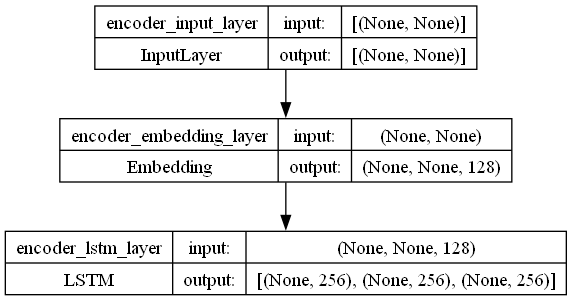

In [23]:
plot_model(model = new_encoder_model, show_shapes= True, show_layer_names= True)

In [25]:
output_dim = 128
lstm_dim = 256
dropout = 0.2
batchsize = 32
epochs = 30

new_decoder_inputs = model.get_layer('decoder_input_layer').input

new_decoder_embedding_layer = model.get_layer('decoder_embedding_layer')

new_decoder_embeddings = new_decoder_embedding_layer(new_decoder_inputs)

new_decoder_state_h = Input(shape = (lstm_dim,), name = 'new_decoder_state_h')
new_decoder_state_c = Input(shape = (lstm_dim,), name = 'new_decoder_state_c')
new_decoder_state = [new_decoder_state_h, new_decoder_state_c]

new_decoder_lstm_layer = model.get_layer('decoder_lstm_layer')

new_decoder_output, decoder_state_h, decoder_state_c = new_decoder_lstm_layer(new_decoder_embeddings, initial_state = new_decoder_state)

new_decoder_final_states = [decoder_state_h, decoder_state_c]

new_decoder_dense_layer = model.get_layer('decoder_dense_layer')

new_decoder_prob_output = new_decoder_dense_layer(new_decoder_output)


new_decoder_model = Model([new_decoder_inputs] + new_decoder_state,
                          [new_decoder_prob_output] + new_decoder_final_states)


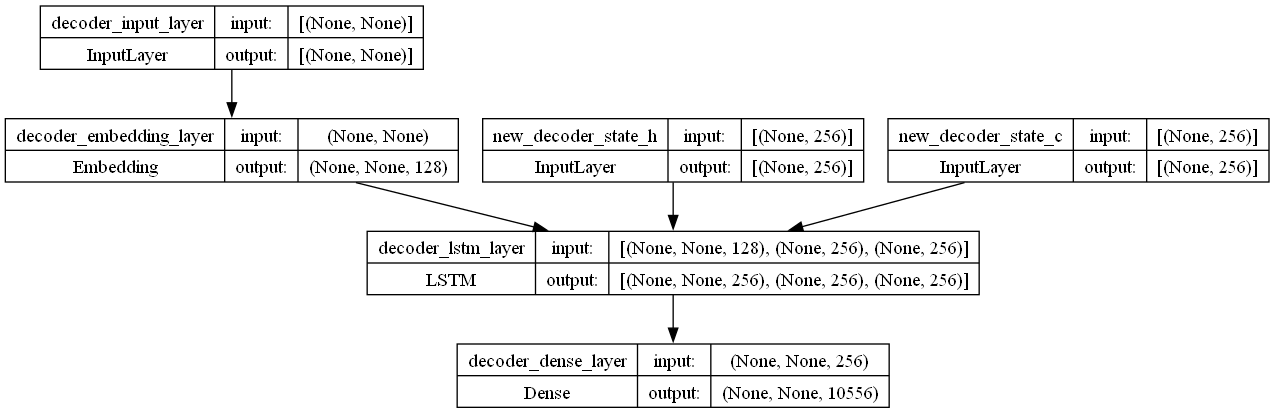

In [26]:
plot_model(model = new_decoder_model, show_shapes = True, show_layer_names = True)

In [29]:
def translation_without_attention(sentence: str, input_tokenizer, encoder, output_tokenizer, decoder, max_translation = 30):
    
    input_seqs = input_tokenizer.texts_to_sequences([sentence])
    
    states = encoder.predict(input_seqs)
    
    current_word = '<sos>'
    decoded_sentence = []
    
    while len(decoded_sentence) < max_translation:
        
        target_seq = np.zeros(shape = (1,1))
        target_seq[0, 0] = output_tokenizer.word_index[current_word]
        target_word_probability , h, c = decoder.predict([target_seq] + states)
        target_token_index = np.argmax(target_word_probability[0, -1, :])
        current_word = output_tokenizer.index_word[target_token_index]
        
        if current_word == '<eos>':
            break
        decoded_sentence.append(current_word)
        
        states = [h, c]
    
    return ' '.join(decoded_sentence)
            

In [30]:
with open('hun_eng_test.txt', encoding = 'utf-8') as file:
    sentences = [line for line in file]

random.seed(1)
sentences = random.sample(sentences, 15)
print(sentences)

['Csinálom.<sep>I got it.\n', 'Mondd el nekem.<sep>Let me know.\n', 'Ritkán járok oda.<sep>I rarely go there.\n', "Mi a döntésed?<sep>What's your decision?\n", "Hol van a legközelebbi étterem?<sep>Where's the closest restaurant?\n", 'Mégis csak van egy megoldás.<sep>There is a solution though.\n', 'Csak pár diák maradt az osztályteremben.<sep>There were few students left in the classroom.\n', 'Nagyra értékelem a segítségedet ebben.<sep>I appreciate your help on this.\n', 'Ez az utolsó vonat.<sep>This is the last train.\n', 'Milyen gyakran jönnek a buszok?<sep>How often do buses come?\n', "A boldogság nem tart örökké.<sep>Happiness doesn't last forever.\n", "Azért vagyok itt, hogy bocsánatot kérjek.<sep>I'm here to apologize.\n", "Tom szörnyű szakács, ugye?<sep>Tom is a terrible cook, isn't he?\n", "Gondolod, hogy ma esni fog?<sep>Do you think it'll rain today?\n", 'Tom ismeri a járást.<sep>Tom knows the way.\n']


In [36]:
def translate_sentences(sentences, translation_function, input_tokenizer, encoder, output_tokenizer, decoder):
    translation_dict = {'Original Sentence': [], 'Human Translation': [], 'Machine Translation': []}
    
    for sent in sentences:
        
        source, target = sent.split('<sep>')
        cleaned_source = text_preprocess(source)
        eng_translation = translation_function(cleaned_source, input_tokenizer, encoder, output_tokenizer, decoder)
        
        translation_dict['Original Sentence'].append(source)
        translation_dict['Human Translation'].append(target.rstrip())
        translation_dict['Machine Translation'].append(eng_translation)
        
    df = pd.DataFrame(translation_dict)
    
    return df
        

In [37]:
df = translate_sentences(sentences, translation_without_attention, hun_tokenizer, new_encoder_model, eng_tokenizer, new_decoder_model)
df

1/1 [==============================] - 0s 13ms/step


,Original Sentence,Human Translation,Machine Translation
0,Csinálom.,I got it.,i'm doing it .
1,Mondd el nekem.,Let me know.,tell me .
2,Ritkán járok oda.,I rarely go there.,i rarely go there .
3,Mi a döntésed?,What's your decision?,what is your decision ?
4,Hol van a legközelebbi étterem?,Where's the closest restaurant?,where's the nearest restaurant ?
5,Mégis csak van egy megoldás.,There is a solution though.,there is just a solution .
6,Csak pár diák maradt az osztályteremben.,There were few students left in the classroom.,we only have a few friends in the classroom .
7,Nagyra értékelem a segítségedet ebben.,I appreciate your help on this.,i appreciate your help .
8,Ez az utolsó vonat.,This is the last train.,this train is last .
9,Milyen gyakran jönnek a buszok?,How often do buses come?,how often do the buses come ?
